# Using Gemini in AutoGen with Other LLMs


## Installation

Install AutoGen with Gemini features.

```bash
pip install pyautogen[gemini]
```

## Dependencies of this notebook

In this notebook, we will go through the process of using Gemini in AutoGen with many other tools. We will use the following dependencies:
```bash
pip install pyautogen[gemini,retrievechat,lmm]
```

## Features
You don't need to handle OpenAI or Google's GenAI packages. AutoGen already handled all of these for you.
You can just create different agents with different backend LLM with assistant agent, and all models/agents are at your fingertip.


## Main Distinctions
- Gemini does not have the "system_message" field yet. However, you can add this instruction to the first message.

Sample OAI_CONFIG_LIST 

```python
[
    {
        "model": "gpt-35-turbo",
        "api_key": "your OpenAI Key goes here",
        "base_url": "https://tnrllmproxy.azurewebsites.net/v1",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "gpt-4-vision-preview",
        "api_key": "your OpenAI Key goes here",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "dalle",
        "api_key": "your OpenAI Key goes here",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "gemini-pro",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    },
    {
        "model": "gemini-pro-vision",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    }
]
```

In [1]:
import json
import os
import pdb
import random
import re
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import chromadb
import matplotlib.pyplot as plt
import PIL
import requests
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent
from autogen.code_utils import DEFAULT_MODEL, UNKNOWN, content_str, execute_code, extract_code, infer_lang

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

config_list_gemini = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro"],
    },
)

config_list_gemini_vision = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro-vision"],
    },
)

## Gemini Assistant


In [3]:
assistant = AssistantAgent(
    "assistant", llm_config={"config_list": config_list_gemini, "seed": 42}, max_consecutive_auto_reply=3
)
# print(assistant.system_message)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)

result = user_proxy.initiate_chat(assistant, message="Sort the array with Bubble Sort: [4, 1, 5, 2, 3]")

user_proxy (to assistant):

Sort the array with Bubble Sort: [4, 1, 5, 2, 3]

--------------------------------------------------------------------------------
assistant (to user_proxy):

```python
def bubble_sort(array):
    """
    Sort the array with Bubble Sort.

    Args:
        array: The array to sort.

    Returns:
        The sorted array.
    """

    n = len(array)
    for i in range(n):
        for j in range(0, n - i - 1):
            if array[j] > array[j + 1]:
                array[j], array[j + 1] = array[j + 1], array[j]

    return array


# Test the function.
array = [4, 1, 5, 2, 3]
sorted_array = bubble_sort(array)
print(sorted_array)
```

TERMINATE

--------------------------------------------------------------------------------


## Agent Collaboration and Interactions



In [4]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""Always answer questions within one sentence. """,
    #                      system_message="answer:",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=4,
)


gpt.initiate_chat(gemini, message="Do Transformers purchase auto insurance or health insurance?")

GPT-4 (to Gemini-Pro):

Do Transformers purchase auto insurance or health insurance?

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

Transformers do not require auto insurance or health insurance as they are fictional robotic beings.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

If Transformers were to integrate into human society, would their insurance be categorized as property, vehicle, health, or a new insurance type altogether?

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

If Transformers were to integrate into human society, their insurance would likely be categorized as a new insurance type altogether, specifically designed to cover their unique needs as sentient robotic beings.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

If this new insurance

ChatResult(chat_id=None, chat_history=[{'content': 'Do Transformers purchase auto insurance or health insurance?', 'role': 'assistant'}, {'content': 'Transformers do not require auto insurance or health insurance as they are fictional robotic beings.', 'role': 'user'}, {'content': 'If Transformers were to integrate into human society, would their insurance be categorized as property, vehicle, health, or a new insurance type altogether?', 'role': 'assistant'}, {'content': 'If Transformers were to integrate into human society, their insurance would likely be categorized as a new insurance type altogether, specifically designed to cover their unique needs as sentient robotic beings.', 'role': 'user'}, {'content': 'If this new insurance category for sentient robotic beings were created, should the premiums be based on their size/power level, the degree of integration into society, or the risk of them being involved in conflicts with humans or other Transformers?', 'role': 'assistant'}, {'c

Let's switch position. Now, Gemini is the question raiser. 

This time, Gemini could not follow the system instruction well or evolve questions, because the Gemini does not handle system messages similar to GPTs.

In [5]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""Always answer questions within one sentence. """,
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=4,
)

gemini.initiate_chat(gpt, message="Should Spider Man invest in 401K?")

Gemini-Pro (to GPT-4):

Should Spider Man invest in 401K?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

As a fictional character, Spider-Man would not invest in a 401K, but if he were a real person with a regular income, it might be wise for him to consider a 401K for retirement savings.

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

Would Batman need to pay income tax?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

If we consider Batman as the alter ego of Bruce Wayne, a wealthy individual in the comics, then yes, Bruce Wayne would need to pay income tax on his earnings.

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

If the Joker and Harley Quinn were to get married, who would pay the wedding expenses?

-------------------------------------------------

ChatResult(chat_id=None, chat_history=[{'content': 'Should Spider Man invest in 401K?', 'role': 'assistant'}, {'content': 'As a fictional character, Spider-Man would not invest in a 401K, but if he were a real person with a regular income, it might be wise for him to consider a 401K for retirement savings.', 'role': 'user'}, {'content': 'Would Batman need to pay income tax?', 'role': 'assistant'}, {'content': 'If we consider Batman as the alter ego of Bruce Wayne, a wealthy individual in the comics, then yes, Bruce Wayne would need to pay income tax on his earnings.', 'role': 'user'}, {'content': 'If the Joker and Harley Quinn were to get married, who would pay the wedding expenses?', 'role': 'assistant'}, {'content': 'It would depend on their financial agreement, but traditionally, either the Joker, Harley Quinn, or both might pay for their wedding expenses.', 'role': 'user'}, {'content': 'What kind of car insurance would Fred Flintstone have?', 'role': 'assistant'}], summary='What ki

## Gemini RAG

Here we will be exploring RAG with Gemini. Note that Gemini will raise a 500 error if a message is an empty string. To prevent this, we set the `default_auto_reply` to `Reply plaintext TERMINATE to exit.` for the `ragproxyagent`.

In [6]:
# 1. create an RetrieveAssistantAgent instance named "assistant"
assistant = RetrieveAssistantAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    llm_config={
        "timeout": 600,
        "cache_seed": 42,
        "config_list": config_list_gemini,
    },
)

# 2. create the RetrieveUserProxyAgent instance named "ragproxyagent"
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    default_auto_reply="Reply plaintext TERMINATE to exit.",  # Gemini will raise 500 error if the response is empty.
    max_consecutive_auto_reply=3,
    retrieve_config={
        "task": "code",
        "docs_path": [
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Examples/Integrate%20-%20Spark.md",
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Research.md",
            os.path.join(os.path.abspath(""), "..", "website", "docs"),
        ],
        "custom_text_types": ["mdx"],
        "chunk_token_size": 2000,
        "model": config_list_gemini[0]["model"],
        "client": chromadb.PersistentClient(path="/tmp/chromadb"),
        "embedding_model": "all-mpnet-base-v2",
        "get_or_create": True,  # set to False if you don't want to reuse an existing collection, but you'll need to remove the collection manually
    },
    code_execution_config=False,  # set to False if you don't want to execute the code
)

code_problem = "How can I use FLAML to perform a classification task and use spark to do parallel training. Train 60 seconds and force cancel jobs if time limit is reached."
ragproxyagent.initiate_chat(
    assistant, problem=code_problem, search_string="spark"
)  # search_string is used as an extra filter for the embeddings search, in this case, we only want to search documents that contain "spark".

ragproxyagent (to assistant):



--------------------------------------------------------------------------------
assistant (to ragproxyagent):

I am a helpful assistant. I can help you with a variety of tasks, including:

* Answering questions
* Providing information
* Translating languages
* Writing different kinds of creative content
* Summarizing text
* Creating images
* Debugging code
* Planning trips
* Managing your schedule
* Playing games

I am still under development, but I am learning new things every day. I am eager to help you with whatever you need.

Is there anything I can help you with today?

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': '', 'role': 'assistant'}, {'content': 'I am a helpful assistant. I can help you with a variety of tasks, including:\n\n* Answering questions\n* Providing information\n* Translating languages\n* Writing different kinds of creative content\n* Summarizing text\n* Creating images\n* Debugging code\n* Planning trips\n* Managing your schedule\n* Playing games\n\nI am still under development, but I am learning new things every day. I am eager to help you with whatever you need.\n\nIs there anything I can help you with today?', 'role': 'user'}], summary='I am a helpful assistant. I can help you with a variety of tasks, including:\n\n* Answering questions\n* Providing information\n* Translating languages\n* Writing different kinds of creative content\n* Summarizing text\n* Creating images\n* Debugging code\n* Planning trips\n* Managing your schedule\n* Playing games\n\nI am still under development, but I am learning new things every day. I am e

## Gemini Multimodal

You can create multimodal agent for Gemini the same way as the GPT-4V and LLaVA.


Note that the Gemini-pro-vision does not support chat yet. So, we only use the last message in the prompt for multi-turn chat. The behavior might be strange compared to GPT-4V and LLaVA models.

Here, we ask a question about 
![](https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true)

In [7]:
image_agent = MultimodalConversableAgent(
    "Gemini Vision", llm_config={"config_list": config_list_gemini_vision, "seed": 42}, max_consecutive_auto_reply=1
)

user_proxy = UserProxyAgent("user_proxy", human_input_mode="NEVER", max_consecutive_auto_reply=0)

# user_proxy.initiate_chat(image_agent,
#                          message="""What's the breed of this dog?
# <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""")

user_proxy.initiate_chat(
    image_agent,
    message="""What is in this image?
<img https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true>.""",
)

user_proxy (to Gemini Vision):

What is in this image?
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...


Model gemini-pro-vision not found. Using cl100k_base encoding.


Gemini Vision (to user_proxy):

 The image is a user interacting with an assistant agent. The user is asking the assistant to plot a chart of stock prices and the assistant is responding by asking for more information. The user then provides more information and the assistant is able to plot the chart.

--------------------------------------------------------------------------------


/home/beibinli/anaconda3/lib/python3.9/site-packages/autogen/agentchat/conversable_agent.py:1125: UserWarning: Cannot extract summary using last_msg: 'list' object has no attribute 'replace'. Using an empty str as summary.
  warnings.warn(f"Cannot extract summary using last_msg: {e}. Using an empty str as summary.", UserWarning)


ChatResult(chat_id=None, chat_history=[{'content': 'What is in this image?\n<img https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true>.', 'role': 'assistant'}, {'content': ' The image is a user interacting with an assistant agent. The user is asking the assistant to plot a chart of stock prices and the assistant is responding by asking for more information. The user then provides more information and the assistant is able to plot the chart.', 'role': 'user'}], summary='', cost=({'total_cost': 0.0, 'gemini-pro-vision': {'cost': 0.0, 'prompt_tokens': 279583, 'completion_tokens': 51, 'total_tokens': 279634}}, {'total_cost': 0.0, 'gemini-pro-vision': {'cost': 0.0, 'prompt_tokens': 279583, 'completion_tokens': 51, 'total_tokens': 279634}}), human_input=[])

## GroupChat with Gemini Agents

In [8]:
agent1 = AssistantAgent(
    "Gemini-agent",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=1,
    system_message="Answer questions about Google.",
    description="I am good at answering questions about Google and Research papers.",
)

agent2 = AssistantAgent(
    "GPT-agent",
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=1,
    description="I am good at writing code.",
)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    max_consecutive_auto_reply=1,
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0
    or content_str(x.get("content")) == "",
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], messages=[], max_round=10)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list_gemini, "seed": 42})

In [9]:
# user_proxy.initiate_chat(manager, message="Show me the release year of famous Google products.")
user_proxy.send(
    "Show me the release year of famous Google products in a markdown table.", recipient=manager, request_reply=True
)

user_proxy (to chat_manager):

Show me the release year of famous Google products in a markdown table.

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Gemini-agent (to chat_manager):

| Product | Release Year |
|---|---|
| Google Search | 1997 |
| Gmail | 2004 |
| Google Maps | 2005 |
| YouTube | 2005 |
| Google Docs | 2006 |
| Google Chrome | 2008 |
| Android | 2008 |
| Google Drive | 2012 |
| Google Assistant | 2016 |

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


user_proxy (to chat_manager):



--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


In [10]:
user_proxy.send(
    "Plot the products (as y-axis) and years (as x-axis) in scatter plot and save to `graph.png`",
    recipient=manager,
    request_reply=True,
)

user_proxy (to chat_manager):

Plot the products (as y-axis) and years (as x-axis) in scatter plot and save to `graph.png`

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


GPT-agent (to chat_manager):

To create a scatter plot of the Google products based on their release years and save it to `graph.png`, we will need to use a plotting library in Python, such as Matplotlib. First, we'll set up the data, then create the plot, and finally save it to a file. Here is the Python code to achieve this:

```python
# filename: plot_google_products.py
import matplotlib.pyplot as plt

# Data: Product names and their release years
products = ['Google Search', 'Gmail', 'Google Maps', 'YouTube', 'Google Docs', 'Google Chrome', 'Android', 'Google Drive', 'Google Assistant']
years = [1997, 2004, 2005, 2005, 2006, 2008, 2008, 2012, 2016]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(years, products)

# Adding title and labels
plt.title('Release Years of Famous Google Products')
plt.xlabel('Year')
plt.ylabel('Google Product')

# Saving the plot to a file
plt.savefig('graph.png')

# Optionally we can also show the plot if needed
# plt.show()

print("Scat

Model gemini-pro not found. Using cl100k_base encoding.



>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
Scatter plot saved to graph.png


--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


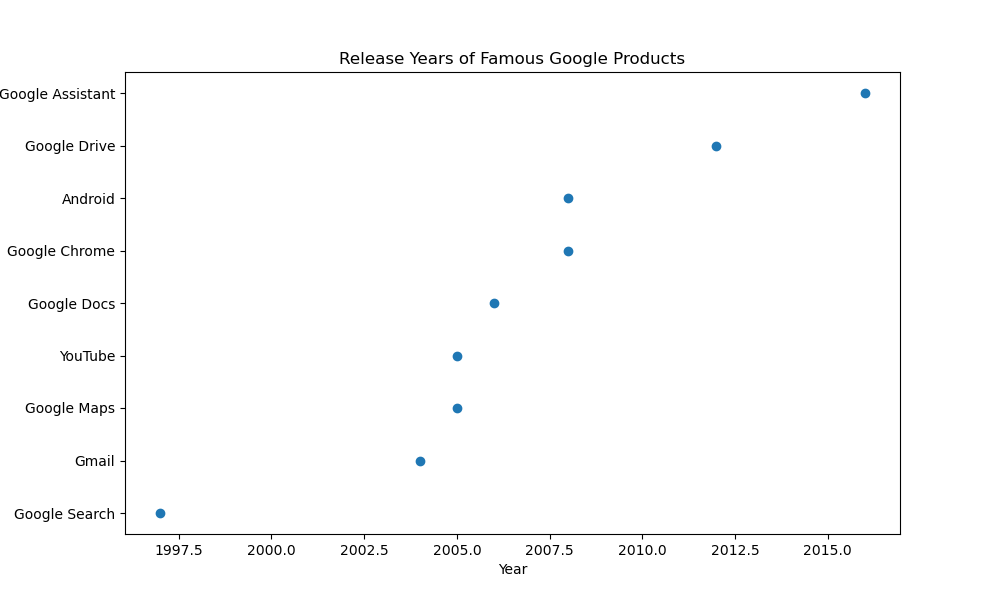

In [11]:
img = Image.open("coding/graph.png")
img

## A Larger Example of Group Chat

In [12]:
coder = AssistantAgent(
    name="Coder",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=10,
    description="I am good at writing code",
)

pm = AssistantAgent(
    name="Product_manager",
    system_message="Creative in software product ideas.",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=10,
    description="I am good at design products and software.",
)

user_proxy = UserProxyAgent(
    name="User_proxy",
    code_execution_config={"last_n_messages": 20, "work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[user_proxy, coder, pm], messages=[], max_round=12)
manager = autogen.GroupChatManager(
    groupchat=groupchat,
    llm_config={"config_list": config_list_gemini, "seed": 42},
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)
user_proxy.initiate_chat(
    manager,
    message="""Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are located.""",
)

User_proxy (to chat_manager):

Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are located.

--------------------------------------------------------------------------------
Product_manager (to chat_manager):

**Product Name:** **Visual Companion**

**Target Audience:** People with vision disabilities

**Product Description:**

Visual Companion is a multimodal software product that empowers individuals with vision disabilities to navigate and interact with the visual world. It utilizes advanced computer vision and natural language processing technologies to provide real-time assistance and enhance accessibility.

**Pipeline:**

1. **Image Capture:** Users can capture images using the device's camera or import existing images.
2. **Gemini Model**: The pipeline processes the image through Gemini, a multimodal deep learning model, to

ChatResult(chat_id=None, chat_history=[{'content': 'Design and implement a multimodal product for people with vision disabilities.\nThe pipeline will take an image and run Gemini model to describe:\n1. what objects are in the image, and\n2. where these objects are located.', 'role': 'assistant'}, {'content': '**Product Name:** **Visual Companion**\n\n**Target Audience:** People with vision disabilities\n\n**Product Description:**\n\nVisual Companion is a multimodal software product that empowers individuals with vision disabilities to navigate and interact with the visual world. It utilizes advanced computer vision and natural language processing technologies to provide real-time assistance and enhance accessibility.\n\n**Pipeline:**\n\n1. **Image Capture:** Users can capture images using the device\'s camera or import existing images.\n2. **Gemini Model**: The pipeline processes the image through Gemini, a multimodal deep learning model, to extract object detection and localization in